# SPARK Dataset


## Imports

In [1]:
from spark_utils import PyTorchSparkDataset, SPARKDataset
from matplotlib import pyplot as plt
from random import randint

Found Pytorch


In [3]:
import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision import models, datasets, tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()

## Defining the Dataset

By default, the output structure of the dataset is not compatible with the models or the transforms (https://pytorch.org/vision/master/transforms.html#v1-or-v2-which-one-should-i-use). To overcome that, we wrap a `PyTorchSparkDataset` in`PyTorchSparkDatasetV2`.

In the code below, we are wrapping images and bounding boxes `torchvision.TVTensor classes` so that we will be able to apply torchvision built-in transformations for the given object detection and segmentation task. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image` and bounding boxes into `torchvision.tv_tensors.BoundingBoxes`. Our dataset now returns a target which is dict where the values are `TVTensors` (all are `torch.Tensor` subclasses).

We also make the dataset compliant with COCO requirements so that it will work for both training and evaluation codes from the COCO reference script.

In [10]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2
class PyTorchSparkDatasetV2(torch.utils.data.Dataset):

    def __init__(self, class_map, split, root_dir, transforms=None):
        super().__init__()
        self.dataset = PyTorchSparkDataset(class_map, split=split, root_dir=root_dir)
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label, bbox = self.dataset[idx]

        img = tv_tensors.Image(img)

        
        bbox = tv_tensors.BoundingBoxes(bbox,
                                        format=tv_tensors.BoundingBoxFormat.XYXY, 
                                        canvas_size=F.get_size(img))
        label = torch.tensor([label])
        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        image_id = idx

        target = {
            'boxes': bbox, 
            'labels': label,
            'area': area, 
            'iscrowd': iscrowd,
            'image_id': image_id, 
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


## Transforms

Let’s now define our pre-processing transforms. All the transforms know how to handle images, bouding boxes and masks when relevant.

Transforms are typically passed as the transforms parameter of the dataset so that they can leverage multi-processing from the `torch.utils.data.DataLoader`.

- http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#transforms-v2-end-to-end-object-detection-segmentation-example
- https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

In [15]:
# Define the transforms to be applied to the data.
def get_transform(is_train):
    transforms = []
    transforms.append(T.ToImage())
    
    if is_train:
        transforms.append(T.RandomPhotometricDistort(p = 0.5))
        transforms.append(T.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomHorizontalFlip(p = 0.5))
        transforms.append(T.SanitizeBoundingBoxes())

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    
    return T.Compose(transforms)


## Loading Datasets

In [16]:
def get_dataset(is_train, class_map, data_path):

    split = "train" if is_train else "validation"

    # We use the PyTorchSparkDatasetV2 class defined above.
    dataset = PyTorchSparkDatasetV2(class_map=class_map, 
                                    split=split, 
                                    root_dir=data_path, 
                                    transforms=get_transform(is_train))

    return dataset

In [17]:
# Set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
# The image sets should be in /data/train, /data/validation and /data/test.
data_path = './data/'

# Define the class map, this is a dictionary that maps the class names to integer labels.
class_map = {'proba_2':0, 'cheops':1, 'debris':2, 'double_star':3, 'earth_observation_sat_1':4, 'lisa_pathfinder':5,
                        'proba_3_csc' :6, 'proba_3_ocs':7, 'smart_1':8, 'soho':9, 'xmm_newton':10}

# Define the number of classes
num_classes = len(class_map)

# # Define the datasets for training and validation.
dataset = get_dataset(is_train=True, class_map=class_map, data_path=data_path)
dataset_valid = get_dataset(is_train=False, class_map=class_map, data_path=data_path)

print(f"Number of training samples: {len(dataset)}")
print(f"Number of validation samples: {len(dataset_valid)}\n")


Number of training samples: 66000
Number of validation samples: 22000



In [18]:
# Check dataset format for debugging purposes
sample = dataset[0]
image, target = sample

print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print()
print(f"Target type: {type(target)}")
print("Target keys: ", list(target.keys()))
print()
print(f"Boxes type: {type(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print()
print(f"Labels type: {type(target['labels'])}")
print(f"Labels shape: {target['labels'].shape}")
print(f"Labels dtype: {target['labels'].dtype}")


Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 1024, 1024])
Image dtype: torch.float32

Target type: <class 'dict'>
Target keys:  ['boxes', 'labels', 'area', 'iscrowd', 'image_id']

Boxes type: <class 'torch.Tensor'>
Boxes shape: torch.Size([1, 4])

Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([1])
Labels dtype: torch.int64


## Visualizing Images

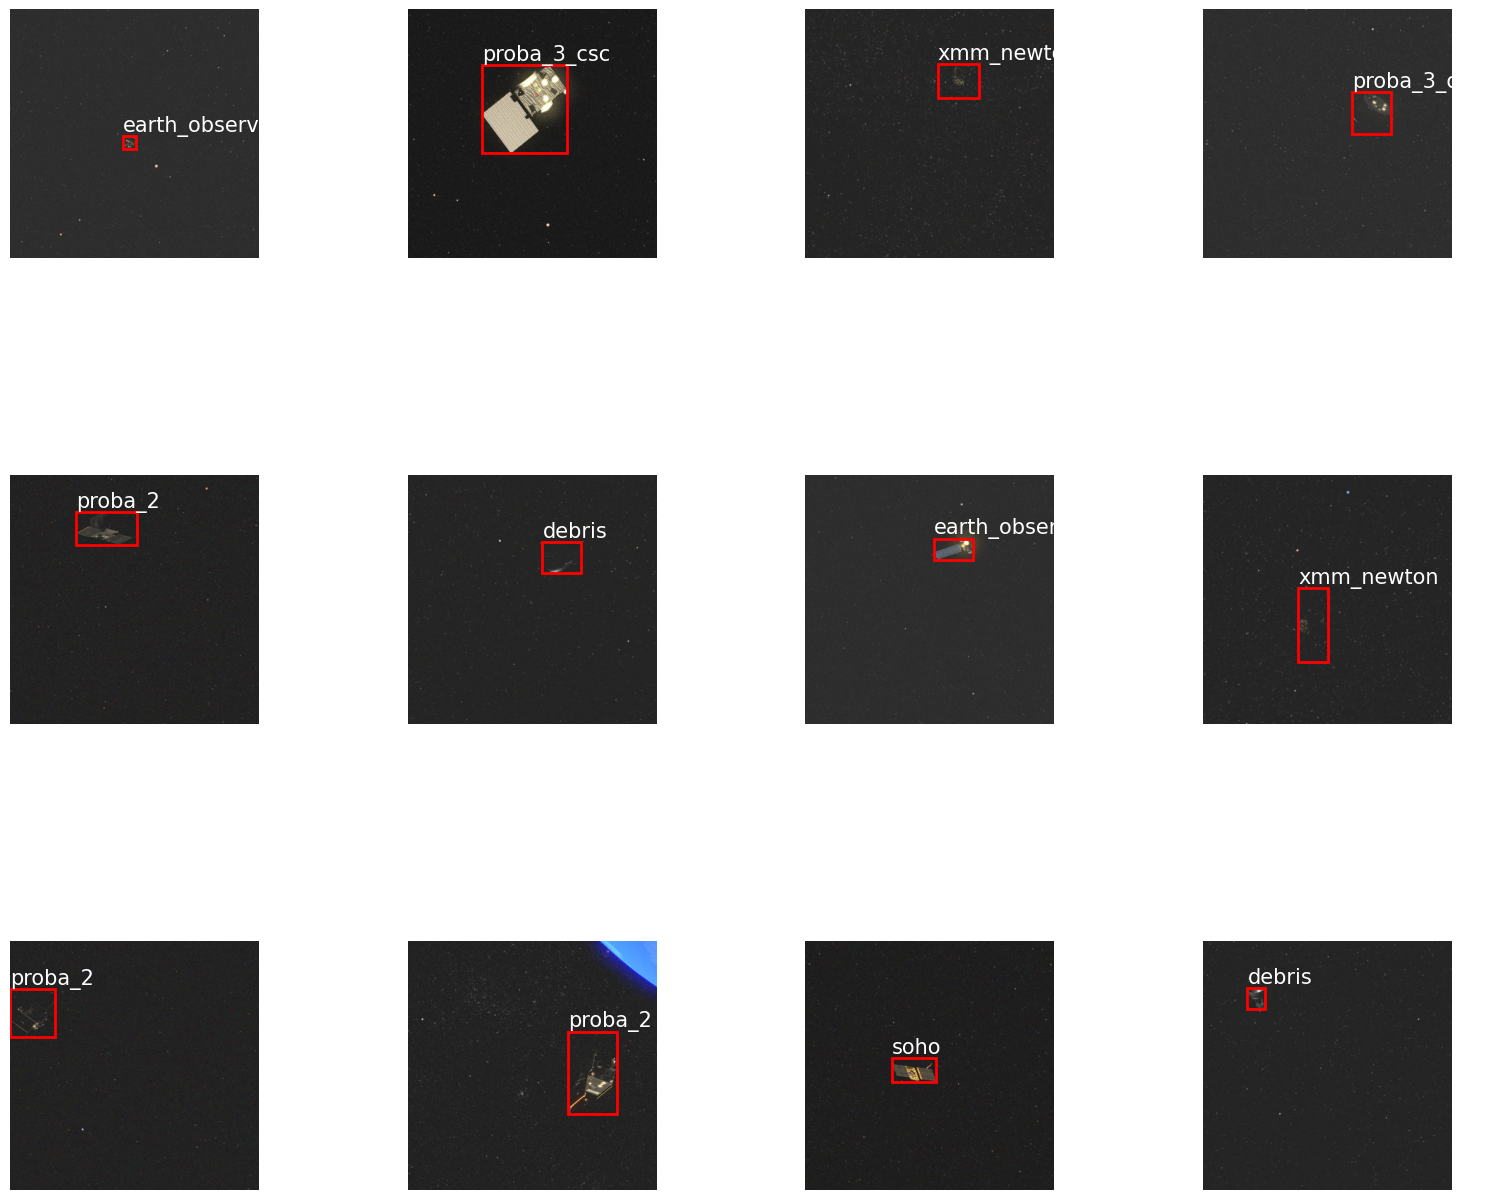

In [19]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path,split='train')

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(dataset)),
                     size=(10,10),
                     ax=axes[i][j])
        axes[i][j].axis('off')

fig.tight_layout()


## Define Dataloaders

In [20]:
# Define the batch size to be used.
batch_size = 10

# Define the dataloaders for training and validation.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

## Defining Model

We will be using Faster R-CNN V2. Faster R-CNN V2 is a model that predicts both bounding boxes and class scores for potential objects in the image. It works similarly to Faster R-CNN with ResNet-50 FPN backbone.

We will start from a model pre-trained on COCO and finetune it for our particular classes in order to perform transfer learning.

- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html
- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [21]:
# Define the model
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    # TODO: Experiment with other weights such as 'COCO_V1'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## Model Training

Below is the main function which performs the training and the validation

In [181]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)

Epoch: [0]  [0/3]  eta: 0:01:58  lr: 0.002503  loss: 1.1445 (1.1445)  loss_classifier: 1.0283 (1.0283)  loss_box_reg: 0.0250 (0.0250)  loss_objectness: 0.0867 (0.0867)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 39.3634  data: 0.1602
Epoch: [0]  [2/3]  eta: 0:00:39  lr: 0.005000  loss: 1.1445 (1.0402)  loss_classifier: 1.0283 (0.9128)  loss_box_reg: 0.0250 (0.0241)  loss_objectness: 0.0867 (0.0974)  loss_rpn_box_reg: 0.0057 (0.0059)  time: 39.3839  data: 0.1341
Epoch: [0] Total time: 0:01:58 (39.3852 s / it)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [0/3]  eta: 0:00:35  model_time: 11.6013 (11.6013)  evaluator_time: 0.0089 (0.0089)  time: 11.7245  data: 0.1142
Test:  [2/3]  eta: 0:00:11  model_time: 11.6013 (11.5169)  evaluator_time: 0.0140 (0.0133)  time: 11.6403  data: 0.1072
Test: Total time: 0:00:34 (11.6405 s / it)
Averaged stats: model_time: 11.6013 (11.5169)  evaluator_time: 0.0140 (0.0133)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [0/3]  eta: 0:00:35  model_time: 11.8369 (11.8369)  evaluator_time: 0.0013 (0.0013)  time: 11.9528  data: 0.1146
Test:  [2/3]  eta: 0:00:11  model_time: 11.6446 (11.6401)  evaluator_time: 0.0011 (0.0011)  time: 11.7541  data: 0.1116
Test: Total time: 0:00:35 (11.7543 s / it)
Averaged stats: model_time: 11.6446 (11.6401)  evaluator_time: 0.0011 (0.0011)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [0/3]  eta: 0:00:36  model_time: 12.1428 (12.1428)  evaluator_time: 0.0014 (0.0014)  time: 12.2639  data: 0.1196
Test:  [2/3]  eta: 0:00:12  model_time: 11.8641 (11.9491)  evaluator_time: 0.0012 (0.0013)  time: 12.0645  data: 0.1129
Test: Total time: 0:00:36 (12.0647 s / it)
Averaged stats: model_time: 11.8641 (11.9491)  evaluator_time: 0.0012 (0.0013)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [0/3]  eta: 0:00:37  model_time: 12.4209 (12.4209)  evaluator_time: 0.0014 (0.0014)  time: 12.5579  data: 0.1355
Test:  [2/3]  eta: 0:00:11  model_time: 11.2542 (11.5377)  evaluator_time: 0.0011 (0.0012)  time: 11.6583  data: 0.1181
Test: Total time: 0:00:34 (11.6585 s / it)
Averaged stats: model_time: 11.2542 (11.5377)  evaluator_time: 0.0011 (0.0012)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [0/3]  eta: 0:00:36  model_time: 12.1510 (12.1510)  evaluator_time: 0.0012 (0.0012)  time: 12.2725  data: 0.1203
Test:  [2/3]  eta: 0:00:12  model_time: 12.1510 (12.3631)  evaluator_time: 0.0011 (0.0011)  time: 12.4776  data: 0.1119
Test: Total time: 0:00:37 (12.4778 s / it)
Averaged stats: model_time: 12.1510 (12.3631)  evaluator_time: 0.0011 (0.0011)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 